# Investigation of Credit Card Customer Default

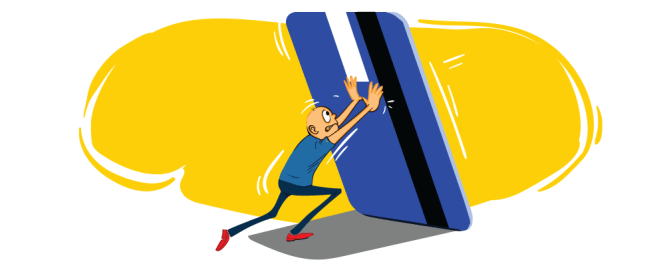

##### In the peresent notebook, I am trying to analyze the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) data set. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled `default.payment.next.month` in the data. 
##### For this, a Machine Learning pipeline is built to analyze the impact of the features on the target and make predictions down the road.

In [2]:
# Your imports
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import altair as alt


# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LogisticRegression, Ridge

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_selection import RFE, RFECV

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score
)

##### 1- Understanding the problem

In [3]:
credit_df = pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv' , index_col = 0)
credit_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29998,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1


This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. The target predicts whether a client **will** default on their credit card payment (class `1`) **or not** (class `0`).

##### 2- Splitting the data

In [4]:
# Splitting the data into train and test sets
train_df, test_df = train_test_split(credit_df, test_size=0.2, random_state=123)
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
19683,200000.0,2,2,1,46,0,0,0,0,0,...,103422.0,95206.0,65108.0,3692.0,5000.0,3300.0,2500.0,2930.0,1500.0,0
11063,120000.0,2,1,1,32,-1,-1,-1,-1,-1,...,476.0,802.0,326.0,652.0,326.0,476.0,802.0,0.0,326.0,1
198,20000.0,2,1,2,22,0,0,0,0,-1,...,8332.0,18868.0,19247.0,1500.0,1032.0,541.0,20000.0,693.0,1000.0,0
23621,100000.0,2,5,2,34,0,0,0,0,0,...,23181.0,7721.0,3219.0,5004.0,3811.0,3002.0,4000.0,3219.0,1864.0,0
26032,290000.0,2,2,2,29,0,0,0,0,0,...,8770.0,9145.0,10016.0,1130.0,1502.0,1300.0,500.0,1000.0,1001.0,0


##### 3- Explaratory Data Analysis

Now let's run an EDA on the train set.

In [5]:
# Performing EDA on the train set
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
19683,200000.0,2,2,1,46,0,0,0,0,0,...,103422.0,95206.0,65108.0,3692.0,5000.0,3300.0,2500.0,2930.0,1500.0,0
11063,120000.0,2,1,1,32,-1,-1,-1,-1,-1,...,476.0,802.0,326.0,652.0,326.0,476.0,802.0,0.0,326.0,1
198,20000.0,2,1,2,22,0,0,0,0,-1,...,8332.0,18868.0,19247.0,1500.0,1032.0,541.0,20000.0,693.0,1000.0,0
23621,100000.0,2,5,2,34,0,0,0,0,0,...,23181.0,7721.0,3219.0,5004.0,3811.0,3002.0,4000.0,3219.0,1864.0,0
26032,290000.0,2,2,2,29,0,0,0,0,0,...,8770.0,9145.0,10016.0,1130.0,1502.0,1300.0,500.0,1000.0,1001.0,0


How about a general overview of the train set!

In [6]:
# Overview of the train set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19683 to 19967
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   24000 non-null  float64
 1   SEX                         24000 non-null  int64  
 2   EDUCATION                   24000 non-null  int64  
 3   MARRIAGE                    24000 non-null  int64  
 4   AGE                         24000 non-null  int64  
 5   PAY_0                       24000 non-null  int64  
 6   PAY_2                       24000 non-null  int64  
 7   PAY_3                       24000 non-null  int64  
 8   PAY_4                       24000 non-null  int64  
 9   PAY_5                       24000 non-null  int64  
 10  PAY_6                       24000 non-null  int64  
 11  BILL_AMT1                   24000 non-null  float64
 12  BILL_AMT2                   24000 non-null  float64
 13  BILL_AMT3                  

**Above is the overall information about the train dataframe, the `Columns`, `Non-Null Counts` and `Data Types`.**

In [7]:
# Summary of statistics of the train set
train_df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,-0.265583,...,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958,0.222167
std,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,1.136707,...,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645,0.415711
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


**Above is the statistical information about different features in the train dataframe.**

In [8]:
# Examining the distribution of the target values in target (class imbalance)
dist = train_df["default.payment.next.month"].value_counts(normalize=True)
dist[0]
dist_df = pd.DataFrame([
      {"Target": "Target: 0", "Distribution": dist[0]},
      {"Target": "Target: 1", "Distribution": dist[1]}

])

# Examining the distribution of the target values in target (class imbalance)
alt.Chart(dist_df).mark_bar().encode(
    x=alt.X('Target'),
    y='Distribution')

alt.Chart(...)

**Above is a visualization to demonstrate the distribution of the target, which proves the class imbalance**

The initial observations of the data can be summarized below:

- There are no NaN values so there is no need for imputation. 
- We have class imbalance since almost 78% of the target class is "0" (client WILL NOT default) and only 22% is "1" (client WILL default). We need to deal with this, since the "1" class (client WILL default) is what we want to spot and care about whereas in this case, the number of the observations in the target is biased towards the "0" class. 
- Based on the information on the documentation of `the dataset page on Kaggle`: The `SEX` feature has binary values Sex (1 = male; 2 = female)
- Based on the information on the documentation of `the dataset page on Kaggle`: The `MARIIAGE` feature, Marital status (1 = married; 2 = single; 3 = divorce; 0=others), therefore, it is safe to discard the "0" level and assign it to level "3" in Feature Engineering, resulting into: (1 = married; 2 = single; 3 = divorce).
- Based on the information on the documentation of `the dataset page on Kaggle`: The `EDUCATION` feature, Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others), therefore, it is safe to discard the "0", "5" and "6" levels and assign them to level "4" in Feature Engineering, resulting into: (1 = graduate school; 2 = university; 3 = high school; 4 = others)

##### 4- Feature engineering

In [54]:
# Feature engineering on "MARRIAGE"
train_df["MARRIAGE"].replace(0, 3, inplace=True)
train_df["MARRIAGE"].unique()

array([1, 2, 3])

In [10]:
# Feature engineering on "EDUCATION"
train_df["EDUCATION"].replace((0, 5,6), 4, inplace=True)
train_df["EDUCATION"].unique()

array([2, 1, 4, 3])

##### 5- Preprocessing and transformation

Let's first check the columns of the data set one more time.

In [11]:
train_df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

Now let's specify the different features in the data set.

In [12]:
# Identifying different features
categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

target = 'default.payment.next.month'

numeric_features = list(
    set(train_df.columns) - set(categorical_features) - set([target])
)
numeric_features

['BILL_AMT2',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT6',
 'BILL_AMT1',
 'PAY_AMT2',
 'BILL_AMT5',
 'BILL_AMT4',
 'PAY_AMT3',
 'AGE',
 'PAY_AMT5',
 'PAY_AMT4',
 'BILL_AMT3',
 'LIMIT_BAL']

In [13]:
# Splitting X and y for train_df and test_df
X_train, y_train = train_df.drop(columns=["default.payment.next.month"]), train_df["default.payment.next.month"]
X_test, y_test = test_df.drop(columns=["default.payment.next.month"]), test_df["default.payment.next.month"]

Now, I need to built the right transformers for each feature type.

In [14]:
# Defining feature transformers
numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

# Defining the preprocessor (column transformer)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

Now it is time to do the modeling part of the pipeline. I will first start with a Baseline model.

**Note:** Since we want to be conservative and not miss any clients that `WILL default` therefore, `recall` is a good choice of metric for this case and `f1` also is an informative metric because it gives us a score to use during hyperparameter optimization and combines both `recall` and `precision`.

##### 6- Baseline model

In [15]:
# Defining results dict. and scoring metrics
results = {}
scoring=["recall", "f1"]

Below, I will define a function `mean_std_cross_val_scores` to return cross validation scores for any model in the pipeline.

In [16]:
# Defining mean_std_cross_val_scores to store the results (attribution to Varada Kolhatkar)

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, 
                            X_train, y_train, 
                            **kwargs)    
    
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):  
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data = out_col, index = mean_scores.index)

In [17]:
# Cross-validation with DummyClassifier
pipe_dummy = make_pipeline(preprocessor, DummyClassifier(strategy="stratified"))
results['DummyClassifier'] = mean_std_cross_val_scores(pipe_dummy, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results)

,DummyClassifier
fit_time,0.062 (+/- 0.008)
score_time,0.022 (+/- 0.003)
test_recall,0.209 (+/- 0.011)
train_recall,0.223 (+/- 0.008)
test_f1,0.211 (+/- 0.010)
train_f1,0.222 (+/- 0.006)


Since in our case we have class imbalance biased to the "0" class while the "1" class is what we want to spot, we should be expecting poor results from `DummyClassifier`.

##### 7- Linear models

As the first attempt I will be using `LogisticRegression` model.

In [18]:
# Defining pipeline for LogisticRegression with class_weight="balanced" and with max_iter = 1000
pipe_lr = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123))

**Side note**

For hyperparameter optimization `f1` score is used as the metric of interest.

In [ ]:
# Creating a param_grid_random for optimization task  
param_grid_lr = {
                     "logisticregression__C": 10.0**np.arange(-3,3,1)}

random_search_lr= RandomizedSearchCV(pipe_lr, param_distributions=param_grid_lr, n_jobs=-1, scoring="f1")
random_search_lr.fit(X_train, y_train);

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


In [20]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_lr.best_score_)
random_search_lr.best_params_

Best f1 sore from RandomizedSearch: 0.534


{'logisticregression__C': 1.0}

In [21]:
# Using the best estimator from RandomizedSearchCV
best_lr = random_search_lr.best_estimator_
best_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BILL_AMT2', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT6',
                                                   'BILL_AMT1', 'PAY_AMT2',
                                                   'BILL_AMT5', 'BILL_AMT4',
                                                   'PAY_AMT3', 'AGE',
                                                   'PAY_AMT5', 'PAY_AMT4',
                                                   'BILL_AMT3', 'LIMIT_BAL']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [22]:
# Reporting validation scores along with standard deviation
results['LogisticRegression'] = mean_std_cross_val_scores(best_lr, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results)

,DummyClassifier,LogisticRegression
fit_time,0.062 (+/- 0.008),1.834 (+/- 0.294)
score_time,0.022 (+/- 0.003),0.028 (+/- 0.000)
test_recall,0.209 (+/- 0.011),0.581 (+/- 0.017)
train_recall,0.223 (+/- 0.008),0.584 (+/- 0.003)
test_f1,0.211 (+/- 0.010),0.534 (+/- 0.014)
train_f1,0.222 (+/- 0.006),0.537 (+/- 0.004)


According to above results, obviously `LogisticRegression` is getting better validation scores (both `recall` and `f1`) compared to `DummyClassifier`. Since in our case we have `class imbalance` biased to the "0" class while the "1" class is what we want to spot, we should be expecting poor results from `DummyClassifier`.

##### 8- Other classifiers

In [23]:
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

In [24]:
# Defining pipelines for 3 classifiers with class_weight="balanced" 
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(class_weight="balanced", random_state=123))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(class_weight="balanced", random_state=123))

In [25]:
# Defining classifiers 
classifiers = {
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb, 
    'LightGBM' : pipe_lgbm,
}

In [26]:
# Cross-validation with classifiers and storing the results
for (name, model) in classifiers.items():    
    results[name] = mean_std_cross_val_scores(model, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:41] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:46] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:50] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:55] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:00] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:58:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,DummyClassifier,LogisticRegression,Random Forest,XGBoost,LightGBM
fit_time,0.062 (+/- 0.008),1.834 (+/- 0.294),4.626 (+/- 0.071),4.449 (+/- 0.255),0.423 (+/- 0.013)
score_time,0.022 (+/- 0.003),0.028 (+/- 0.000),0.147 (+/- 0.006),0.028 (+/- 0.001),0.031 (+/- 0.001)
test_recall,0.209 (+/- 0.011),0.581 (+/- 0.017),0.345 (+/- 0.026),0.364 (+/- 0.013),0.618 (+/- 0.020)
train_recall,0.223 (+/- 0.008),0.584 (+/- 0.003),1.000 (+/- 0.000),0.587 (+/- 0.010),0.768 (+/- 0.005)
test_f1,0.211 (+/- 0.010),0.534 (+/- 0.014),0.453 (+/- 0.028),0.462 (+/- 0.015),0.533 (+/- 0.015)
train_f1,0.222 (+/- 0.006),0.537 (+/- 0.004),0.999 (+/- 0.000),0.712 (+/- 0.009),0.650 (+/- 0.004)


Based on above results, `LightGBM` model is performing better than `LogisticRegression` whereas, both `RandomForest` and `XGBoost` have lower validation scores (both `recall` and `f1`) compared to `LogisticRegression`. So it is safe to say that `LightGBM` is able to beat `LogisticRegression` in our case. In terms of time, although `LightGBM` is slightly slower that `LogisticRegression` in scoring but in fitting it is much faster. Also, both `RandomForest` and `XGBoost` are in overall, slower models compared to `LogisticRegression`. It is worth mentioning that another observation is the overfitting with `RandomForest` model.

##### 9- Feature selection

**Side note**

For Feature celection, `RFECV()` is used with `LogisticRegression` and validation scores will be compared with plain `LogisticRegression` to better study the effect of possible improvement with feature selection

In [27]:
# Adding RFECV with Ridge to LogisticRegression
lr = LogisticRegression(solver = "liblinear")
pipe_rfe_lr = make_pipeline(preprocessor, RFECV(estimator=lr), LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123))

# Reporting validation scores along with standard deviation
results['RFECVLogisticRegression'] = mean_std_cross_val_scores(pipe_rfe_lr, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results)

,DummyClassifier,LogisticRegression,Random Forest,XGBoost,LightGBM,RFECVLogisticRegression
fit_time,0.062 (+/- 0.008),1.834 (+/- 0.294),4.626 (+/- 0.071),4.449 (+/- 0.255),0.423 (+/- 0.013),59.639 (+/- 1.655)
score_time,0.022 (+/- 0.003),0.028 (+/- 0.000),0.147 (+/- 0.006),0.028 (+/- 0.001),0.031 (+/- 0.001),0.033 (+/- 0.004)
test_recall,0.209 (+/- 0.011),0.581 (+/- 0.017),0.345 (+/- 0.026),0.364 (+/- 0.013),0.618 (+/- 0.020),0.570 (+/- 0.027)
train_recall,0.223 (+/- 0.008),0.584 (+/- 0.003),1.000 (+/- 0.000),0.587 (+/- 0.010),0.768 (+/- 0.005),0.574 (+/- 0.005)
test_f1,0.211 (+/- 0.010),0.534 (+/- 0.014),0.453 (+/- 0.028),0.462 (+/- 0.015),0.533 (+/- 0.015),0.526 (+/- 0.022)
train_f1,0.222 (+/- 0.006),0.537 (+/- 0.004),0.999 (+/- 0.000),0.712 (+/- 0.009),0.650 (+/- 0.004),0.530 (+/- 0.004)


Obviously, the results indicate that the experimented feature selection not only did not improve the scores of (at least) `LogisticRegression` (both `recall` and `f1`), but also slightly lowered the results. Therefore, feature selection will not be kept in the following sections. 

##### 10- Hyperparameter optimization

**Side note**

For hyperparameter optimization `f1` score is used as the metric of interest.

In [28]:
# Defining results_hyper_opt dict. for hyperparameter optimization
results_hyper_opt = {}

**Hyperparameter optimization with RandomForest**

In [29]:
param_grid_rf = {"randomforestclassifier__n_estimators": [5, 10, 50, 100],
                     "randomforestclassifier__max_depth": [10, 20, 30]}

random_search_rf= RandomizedSearchCV(pipe_rf, param_distributions=param_grid_rf, n_jobs=-1, scoring="f1")
random_search_rf.fit(X_train, y_train);

In [30]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_rf.best_score_)
random_search_rf.best_params_

Best f1 sore from RandomizedSearch: 0.538


{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__max_depth': 10}

In [31]:
# Using the best estimator from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BILL_AMT2', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT6',
                                                   'BILL_AMT1', 'PAY_AMT2',
                                                   'BILL_AMT5', 'BILL_AMT4',
                                                   'PAY_AMT3', 'AGE',
                                                   'PAY_AMT5', 'PAY_AMT4',
                                                   'BILL_AMT3', 'LIMIT_BAL']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [32]:
# Reporting validation scores along with standard deviation
results_hyper_opt['Optimized RandomForest'] = mean_std_cross_val_scores(best_rf, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results_hyper_opt)

,Optimized RandomForest
fit_time,2.912 (+/- 0.037)
score_time,0.086 (+/- 0.001)
test_recall,0.565 (+/- 0.017)
train_recall,0.662 (+/- 0.005)
test_f1,0.538 (+/- 0.015)
train_f1,0.626 (+/- 0.003)


**Hyperparameter optimization with XGBoost**

In [33]:
param_grid_xgb = {"xgbclassifier__subsample": [0.6, 0.8, 1.0]
                     }

random_search_xgb= RandomizedSearchCV(pipe_xgb, param_distributions=param_grid_xgb, n_jobs=-1, n_iter=1000, scoring="f1")
random_search_xgb.fit(X_train, y_train);

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 3 is smaller than n_iter=1000. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_xgb.best_score_)
random_search_xgb.best_params_

Best f1 sore from RandomizedSearch: 0.467


{'xgbclassifier__subsample': 0.8}

In [35]:
# Using the best estimator from RandomizedSearchCV
best_xgb = random_search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)

[09:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BILL_AMT2', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT6',
                                                   'BILL_AMT1', 'PAY_AMT2',
                                                   'BILL_AMT5', 'BILL_AMT4',
                                                   'PAY_AMT3', 'AGE',
                                                   'PAY_AMT5', 'PAY_AMT4',
                                                   'BILL_AMT3', 'LIMIT_BAL']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [36]:
# Reporting validation scores along with standard deviation
results_hyper_opt['Optimized XGBoost'] = mean_std_cross_val_scores(best_xgb, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(results_hyper_opt)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:26] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:30] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:35] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:40] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:12:45] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:12:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Optimized RandomForest,Optimized XGBoost
fit_time,2.912 (+/- 0.037),4.734 (+/- 0.360)
score_time,0.086 (+/- 0.001),0.029 (+/- 0.000)
test_recall,0.565 (+/- 0.017),0.373 (+/- 0.013)
train_recall,0.662 (+/- 0.005),0.623 (+/- 0.006)
test_f1,0.538 (+/- 0.015),0.467 (+/- 0.015)
train_f1,0.626 (+/- 0.003),0.739 (+/- 0.003)


##### 11- Interpretation and feature importance

**Side note**

To carry out feature importance evaluation, we will be using `LightGBM` as one of the best performing models for this example.

In [37]:
# Fitting the RandomForestClassifier on the train split
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BILL_AMT2', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT6',
                                                   'BILL_AMT1', 'PAY_AMT2',
                                                   'BILL_AMT5', 'BILL_AMT4',
                                                   'PAY_AMT3', 'AGE',
                                                   'PAY_AMT5', 'PAY_AMT4',
                                                   'BILL_AMT3', 'LIMIT_BAL']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [38]:
# Getting feature names
ohe_feature_names = (
    pipe_lgbm.named_steps["columntransformer"].named_transformers_["pipeline-2"].named_steps["onehotencoder"].get_feature_names().tolist()
    
)
feature_names = numeric_features + ohe_feature_names
feature_names[:20]

['BILL_AMT2',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT6',
 'BILL_AMT1',
 'PAY_AMT2',
 'BILL_AMT5',
 'BILL_AMT4',
 'PAY_AMT3',
 'AGE',
 'PAY_AMT5',
 'PAY_AMT4',
 'BILL_AMT3',
 'LIMIT_BAL',
 'x0_1',
 'x0_2',
 'x1_1',
 'x1_2',
 'x1_3',
 'x1_4']

In [39]:
# Examining feature importances for LightGBM pipeline
importance_data = {
    "Importance": pipe_lgbm.named_steps["lgbmclassifier"].feature_importances_,
}
importance_df = pd.DataFrame(
    data=importance_data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)[:20]

importance_df

,Importance
BILL_AMT1,257
PAY_AMT3,223
PAY_AMT2,204
LIMIT_BAL,198
PAY_AMT6,188
PAY_AMT1,172
PAY_AMT4,166
AGE,163
PAY_AMT5,161
BILL_AMT2,160


Based on above results, the `BILL_AMT1` and `PAY_AMT3` features are of the biggest drivers of the predictions. However, from only these results, we can not determine the direction to which these features drive the predictions as there is no sign associated with them (all positive numbers) and also the fact that `LGBMClassifier` is a non-linear model.

In [40]:
import shap

### BEGIN STARTER CODE (attribution to Varada Kolhatkar)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

### END STARTER CODE

,BILL_AMT2,BILL_AMT6,PAY_AMT1,PAY_AMT6,BILL_AMT1,PAY_AMT2,BILL_AMT5,BILL_AMT4,PAY_AMT3,AGE,...,x8_-2,x8_-1,x8_0,x8_2,x8_3,x8_4,x8_5,x8_6,x8_7,x8_8
ID,,,,,,,,,,,,,,,,,,,,,
19683,0.761414,0.444775,-0.117221,-0.207312,0.757746,-0.042650,0.901952,0.929712,-0.110198,1.140423,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11063,-0.684308,-0.646675,-0.298634,-0.271741,-0.647736,-0.261604,-0.648784,-0.664583,-0.267318,-0.378471,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
198,-0.415538,-0.327893,-0.248029,-0.234752,-0.443283,-0.228531,-0.352021,-0.542919,-0.263701,-1.463396,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23621,0.595190,-0.597934,-0.038927,-0.187336,0.553566,-0.098349,-0.535129,-0.312957,-0.126778,-0.161486,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26032,-0.573988,-0.483417,-0.270109,-0.234697,-0.596367,-0.206514,-0.511737,-0.536136,-0.221473,-0.703949,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Extracting shapely values for the first 1000 examples from the training set
lgbm = LGBMClassifier()
lgbm.fit(X_train_enc, y_train)
X_train_sample = X_train_enc.sample(1000, random_state=2)
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [42]:
### BEGIN STARTER CODE (attribution to Varada Kolhatkar)

values = shap_values[0][0]
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

### END STARTER CODE

,SHAP
x3_2,0.220565
LIMIT_BAL,0.182999
BILL_AMT1,0.157704
PAY_AMT1,0.108599
PAY_AMT4,0.103836
...,...
x1_1,-0.029114
PAY_AMT6,-0.031072
BILL_AMT2,-0.040267
BILL_AMT6,-0.048146


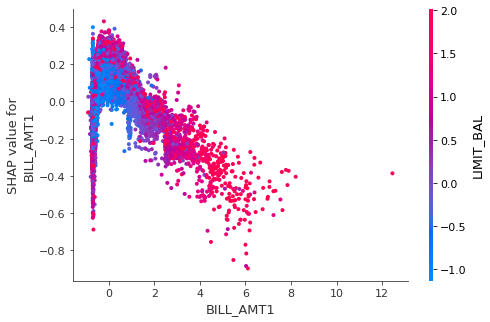

In [43]:
shap.dependence_plot("BILL_AMT1", shap_values[0], X_train_enc)

The plot above shows the effect of `BILL_AMT1` feature on the prediction. Each dot is a single prediction for 1000 examples. Here, the x-axis represents values of the feature `BILL_AMT1` and the y-axis is the `SHAP` value for that feature, which represents how much knowing that feature's value changes the output.  Obviously, higher values of `BILL_AMT1` result in lower `SHAP` values for class "0" of the target. Also, the color corresponds to a second feature (`LIMIT_BAL`) that may have an interaction effect with `BILL_AMT1`.

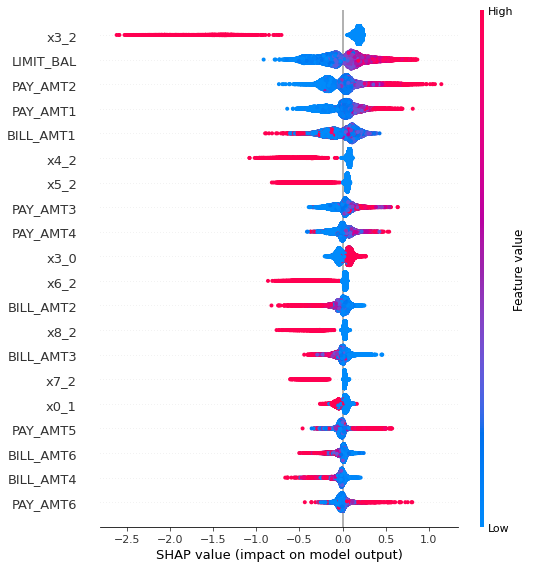

In [44]:
shap.summary_plot(shap_values[0], X_train_enc)

The plot shows the most important features for predicting the class. It also shows the direction of how it is going to drive the prediction. Higher `SHAP` value means positive association with class "0" of the target as we are using `SHAP` values for class 0. As an example, higher value of `x5_2` feature has a high negative impact on the prediction of the target as class "0", or higher value of `LIMIT_BAL` feature has a high positive impact on the prediction of the target as class "0".

###### 12- Results on the test set

**Side note**

Using `LightGBM` as the best performing model for this section.

In [45]:
# Fitting LightGBM model on X_train and y_train and scoring on the X_test and y_test
pipe_lgbm.fit(X_train, y_train)
print("f1 score for the test set: %.3f" % f1_score(y_test, pipe_lgbm.predict(X_test)))

f1 score for the test set: 0.534


In [46]:
print("Recall score for the test set: %.3f" % recall_score(y_test, pipe_lgbm.predict(X_test)))

Recall score for the test set: 0.638


Based on the results, the test scores above agree well with the validation scores from before. Also, since our dataset is large and the validation set is not hit too many times therefore, we will not suffer from `optimization bias` or `overfitting the validation set`.

In [47]:
# Encoding the test set
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,BILL_AMT2,BILL_AMT6,PAY_AMT1,PAY_AMT6,BILL_AMT1,PAY_AMT2,BILL_AMT5,BILL_AMT4,PAY_AMT3,AGE,...,x8_-2,x8_-1,x8_0,x8_2,x8_3,x8_4,x8_5,x8_6,x8_7,x8_8
ID,,,,,,,,,,,,,,,,,,,,,
25666,-0.346026,-0.337159,-0.259964,0.259165,-0.300983,-0.230030,0.061206,-0.671954,-0.293801,-1.029426,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16465,0.296127,0.181306,-0.145865,-0.179543,0.335277,-0.178220,0.165482,0.115932,-0.182527,2.550825,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22387,1.543630,2.227535,0.068249,-0.234752,1.429288,0.027617,2.099254,1.768395,-0.293801,-0.595456,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10150,-0.678558,-0.652167,-0.293263,-0.289632,-0.374887,-0.276875,-0.661958,-0.671954,-0.293801,0.597961,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8730,-0.575956,-0.490140,-0.269512,-0.271522,-0.584234,-0.223004,-0.507269,-0.529090,-0.275385,0.814945,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Checking the prediction on the following example**

In [48]:
lgbm.predict(X_test_enc)[5]

0

**Explaining with SHAP force plot**

**Force Plot**

In [49]:
# load JS visualization code to notebook
shap.initjs()

In [50]:
shap.force_plot(
    explainer.expected_value[0], shap_values[0][5, :], X_test_enc.iloc[5, :]
)

According to the plot, the base value for class "0" is 1.581 whereas the score for class "0" here is 1.72. Features that push the prediction to a higher value are in red, such as `BILL_AMT1` or `PAY_AMT1` and in blue, are features that push the prediction to a lower value such as `LIMIT_BAL` or `BILL_AMT2`. As an example, it is safe to say that higher values for `x3_0` are likely to predict class "0" for the target.

### Conclusions

In [51]:
# Tabulating important results
results_df = pd.DataFrame([
      {"Classifier": "DummyClassifier", "Mean recall score": 0.233, "Mean f1 score": 0.232},
      {"Classifier": "LogisticRegression", "Mean recall score": 0.581, "Mean f1 score": 0.534},
      {"Classifier": "Random Forest", "Mean recall score": 0.344, "Mean f1 score": 0.452},
      {"Classifier": "XGBoost", "Mean recall score": 0.366, "Mean f1 score": 0.465},
      {"Classifier": "LightGBM", "Mean recall score": 0.618, "Mean f1 score": 0.533},
      {"Classifier": "Test with LightGBM", "Mean recall score": 0.638, "Mean f1 score": 0.534},




])
results_df

,Classifier,Mean recall score,Mean f1 score
0,DummyClassifier,0.233,0.232
1,LogisticRegression,0.581,0.534
2,Random Forest,0.344,0.452
3,XGBoost,0.366,0.465
4,LightGBM,0.618,0.533
5,Test with LightGBM,0.638,0.534


In [52]:
# Plotting recall and f1 scores for different classifiers
recall_line = alt.Chart(results_df, title='Recall Scores Plot').mark_line().encode(
    x='Classifier',
    y='Mean recall score',
    color= alt.value('black'))
recall_point = alt.Chart(results_df).mark_point().encode(
    x='Classifier',
    y='Mean recall score',
     color= alt.value('black'))
f1_line = alt.Chart(results_df, title='f1 Scores Plot').mark_line().encode(
    x='Classifier',
    y='Mean f1 score',
    color= alt.value('black'))
f1_point = alt.Chart(results_df).mark_point().encode(
    x='Classifier',
    y='Mean f1 score',
     color= alt.value('black'))


(recall_line + recall_point).properties(
    width=500,
    height=300) | (f1_line + f1_point).properties(
    width=500,
    height=300
)

alt.HConcatChart(...)

Since the project is open-ended, there is still room for improvement. We can go much deeper in `Preprocessing`, `Feature Selection`, `Feature Engineering` and `Hyperparameter Optimization`. We can also investigate the performance of other classifiers as well and even make attempts to tune them to get better validation scores. We can summarize the concluding remarks as below:
- As expected `DummyClassifier` has the lowest performance compared to other models and the fact that we have class imbalance within the target makes the results from `DummyClassifier` even more unreliable.
- For our case, a linear model like `LogisticRegression` has an average performance where tree_based models such as `RandomForest` and `XGBoost` have scores lower than `LogisticRegression`. However, `LightGBM` performs relatively better than linear `LogisticRegression`.
- For the case under study, the performed feature selection with `REFCV` did not improve the scores of `LogisticRegression`. Perhaps if enough time is spent on this process, better results are not far from reach.
- Signs of improvement in validation scores are observed with hyperparameter optimization. This is another field which, as mentioned earlier, has the potential to better the scores.
- `LightGBM` classifier, as the best performing model, was applied to the test set for which test results agreed well with validation scores and since the dataset is large enough, there is no concern with `optimization bias` for our case.